# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

In [4]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    550      0 --:--:-- --:--:-- --:--:--   550
100 1546k  100 1546k    0     0  1497k      0  0:00:01  0:00:01 --:--:-- 1497k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    468      0 --:--:-- --:--:-- --:--:--   468
100  385k  100  385k    0     0   380k      0  0:00:01  0:00:01 --:--:--  380k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1065      0 --:--:-- --:--:-- --:--:--  1063
100  230k  100  230k    0     0   402k      0 --:--:-- --:--:-- --:--:--  402k


In [5]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 632kB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420111 sha256=bc9f3570a771d8cb3c19e9a3f5c917098900fe3c286ee021a00475244beade91
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [6]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [7]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [8]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [9]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [10]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [11]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [12]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [13]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [14]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [15]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [16]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [17]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [18]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** ALS es un modelo que se utiliza se basa en los fundamentos de la factorización de matrices y busca optimizar el modelo en forma iterativa para que en cada iteración se pueda acercar cada vez más a la representación factorizada del dataset original.

In [19]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [20]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                       Contact (1997)
256    When the Cats Away (Chacun cherche son chat) (...
409                                          Jack (1996)
292                                      Rosewood (1997)
754                                    Red Corner (1997)
864                           My Fellow Americans (1996)
813                         Celluloid Closet, The (1995)
321                                        Mother (1996)
240               Beavis and Butt-head Do America (1996)
136                  Mr. Smith Goes to Washington (1939)
Name: title, dtype: object

In [21]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06563147753908684
ndcg: 0.32465543644716693


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

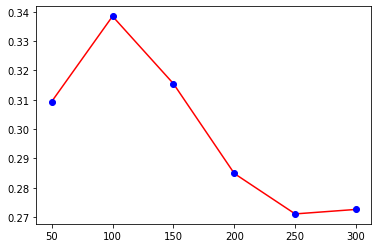

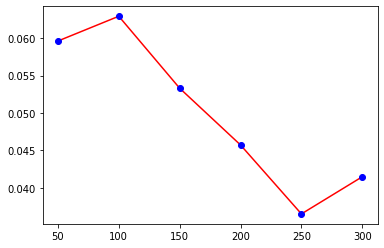

In [34]:
factors = [50, 100, 150, 200, 250, 300]
maps = []
ncdg = []

for c in factores:
  model_als = implicit.als.AlternatingLeastSquares(factors=c, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  maps.append(maprec)
  ncdg.append(ndcg)


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(factors, ncdg, 'r-')
plt.plot(factors, ncdg, 'bo')
plt.show()

plt.plot(factors, maps, 'r-')
plt.plot(factors, maps, 'bo')
plt.show()


## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.
**Respuesta:** El enfoque BPR se basa en generar tripletas de usuario para los datos de entrenamiento, con items positivos y negativos resultantes del tipo de interacción de los usuarios. La optimización se basa en que la predicción se centra en las preferencias del usuario respecto a pares de items más que la valoración de los ítems específicos. Contiene un criterio de optimización y un algoritmo de aprendizaje LearnBPR.

In [26]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [27]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
327                                   Cop Land (1997)
285                             Secrets & Lies (1996)
746                                Real Genius (1985)
299                                    Hoodlum (1997)
312    Midnight in the Garden of Good and Evil (1997)
301                                   In & Out (1997)
244                     Smilla's Sense of Snow (1997)
99             Snow White and the Seven Dwarfs (1937)
300                              Air Force One (1997)
Name: title, dtype: object

In [28]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
173         Princess Bride, The (1987)
194                  Sting, The (1973)
21       Muppet Treasure Island (1996)
175                      Brazil (1985)
172    Empire Strikes Back, The (1980)
68                    Crow, The (1994)
27                     Bad Boys (1995)
203                  Unforgiven (1992)
Name: title, dtype: object

In [29]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.056857979698330806
ndcg: 0.3537519142419602


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

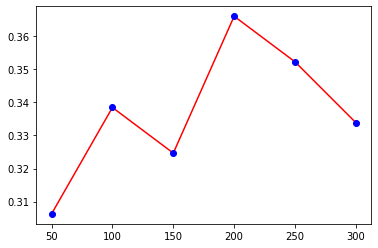

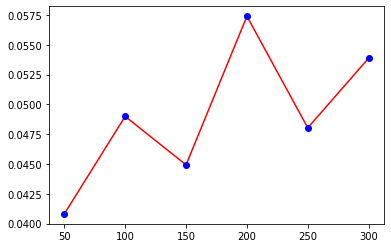

In [33]:
factors = [50, 100, 150, 200, 250, 300]
maps = []
ncdg = []

for c in factors:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=c, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)
  maps.append(maprec)
  ncdg.append(ndcg)


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(factors, ncdg, 'r-')
plt.plot(factors, ncdg, 'bo')
plt.show()

plt.plot(factors, maps, 'r-')
plt.plot(factors, maps, 'bo')
plt.show()
